In [1]:
import numpy as np
from scipy.integrate import dblquad
from scipy.integrate import quad
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 300,
})

class fixed_values:
  def __init__(self):
    self.h=4.135667e-9 #eV us
    self.hbar=self.h/(2*np.pi) #eV us rad-1
    self.c=299792458 #um/us
    self.k_B=8.617343e-5 #eV/K
    self.eta_pb_max=0.59
    self.energy_au=27.211386 #eV
    self.time_au=2.418884e-11 #us
    self.length_au=5.291772e-5 #um
    self.N_A = 6.022e23
    self.m_e = 5.68563006e-12 #eV s2 m-2
consts = fixed_values()

In [2]:
def calc_RS(metal,T):
    beta = (2/3 * metal.e_fermi)**2 * metal.nue/(2*metal.rho_m*metal.v_L**2)
    tau_epsilon = 1/(np.pi**4*beta/5 * metal.p_fermi*metal.l*T**4/(metal.p_fermi*metal.v_T)**3 * (1+3/2*(metal.v_L/metal.v_T)**5) * consts.k_B**4 / consts.hbar**2)
    tau_0 = 4.20*tau_epsilon # kaplan 18
    return tau_0

def calc_KSK(metal):
  qD = metal.E_D/(consts.hbar*metal.v_L)

  Phi_L = lambda x : 2/np.pi * ((x*np.arctan(x))/(x-np.arctan(x)) - 3/x)
  Phi_T = lambda x : 3/np.pi * (2*x**3 + 3*x - 3*(x**2+1) * np.arctan(x))/x**4
  gL =  metal.p_fermi**2 / (3*consts.m_e*np.sqrt(metal.rho_m)*metal.v_L)

  alpha2F = lambda omega : gL**2 * (metal.mstar*qD**2*omega**2)/(4*metal.p_fermi**2 *metal.T_D**2) * (Phi_L(omega*metal.l/metal.v_L)+(metal.v_L/metal.v_T)**4 * 2 * Phi_T(omega*metal.l/metal.v_T)) * consts.hbar**3 * consts.k_B**-2

  alpha2_av = quad(alpha2F,0,metal.omega_D)[0] / 3
  return alpha2_av

class superconductor():
  def __init__(self,metaldict,disordered=False):
    self.nue = metaldict['nue']
    self.D = metaldict['D']
    self.Tc = metaldict['Tc']
    self.Delta = 1.768*consts.k_B*self.Tc #eV
    self.T_D = metaldict['T_D']
    self.omega_D = consts.k_B*self.T_D/consts.hbar #in MHz rad
    self.E_D = consts.k_B*self.T_D
    self.v_L = metaldict['v_L']
    self.v_T = metaldict['v_T']

    rho_m = metaldict['rho_m (g cm-3)']
    self.Z = metaldict['Z']
    m_a = metaldict['m_a (u)']

    self.N = consts.N_A*rho_m/m_a * 1e-12 # atoms um-3
    self.n = self.N*self.Z # electrons um-3
    self.rho_m = rho_m*6.242e15 *1e-12#eV us2 um-2 um-3

    self.rs = (3/(4*np.pi*self.n))**(1/3)
    self.rs_au = self.rs / consts.length_au
    
    self.p_fermi = np.sqrt((consts.hbar)**2*(3*np.pi**2*self.n)**(2/3))
    self.k_fermi = self.p_fermi/consts.hbar
    self.mstar = 2*consts.hbar**2*self.nue*np.pi**2/self.k_fermi # from suppl, fermi liquid model
    self.v_fermi = self.p_fermi/self.mstar
    self.e_fermi = (consts.hbar)**2/(2*self.mstar)*(3*np.pi**2*self.n)**(2/3)

    self.tau_elastic = self.nue*self.D*self.mstar/self.n # <= Einstein relation (sigma = e^2 N(0) D) and drude effective mass, tau elastic time

    self.l=self.v_fermi*self.tau_elastic


    if disordered==False:
      self.tau_0 = 0.11 #us
      self.alpha2_av = metaldict['alpha2_av']
    else:
      self.tau_0 = calc_RS(self,self.Tc)
      self.alpha2_av = calc_KSK(self)

aluminium = {
    'nue' : 17.2e9, #eV-1 um-3
    'D' : 15000, #um2 us-1
    'Tc' : 1.19, #K
    'T_D' : 428.21, #K
    'v_L' : 6420, #um/us
    'v_T' : 3040, #um/us
    'rho_m (g cm-3)' : 2.7, #g cm-3
    'Z' : 3, #valence electrons per atom
    'm_a (u)' : 26.982, #u
    'alpha2_av' : 1.93e-3, #eV
    'tau_0' : 0.11, #us
}

tantalum = {
    'nue' : 30.3e9, #eV-1 um-3
    'D' : 75, #um2 us-1
    'Tc' : 1.11, #K
    'T_D' : 221, #K
    'v_L' : 4.35e3, #um/us
    'v_T' : 1.74e3, #um/us
    'rho_m (g cm-3)' : 17.1, #g cm-3
    'Z' : 2, #valence electrons per atom
    'm_a (u)' : 180.94788, #u
  }

T=0.02 #K
Al = superconductor(aluminium,disordered=False)
bTa = superconductor(tantalum,disordered=True)

In [3]:
def calc_LP(metal,energy):
    tau_ee = 1/((energy**2 / (consts.hbar*metal.e_fermi))*metal.rs_au**0.5 / 7.96)
    return tau_ee

def calc_pippard(metal,energy):
    omega = energy/consts.hbar

    k_L=omega/metal.v_L
    alpha_L = metal.n*metal.mstar/(metal.rho_m*metal.v_L*metal.tau_elastic) * (1/3 * (k_L**2*metal.l**2*np.arctan(k_L*metal.l)/(k_L*metal.l-np.arctan(k_L*metal.l))) - 1)
    tau_ph_L = 1/(metal.v_L*alpha_L)

    k_T=omega/metal.v_T
    g = 3/(2*k_T**2*metal.l**2)*((k_T**2*metal.l**2+1)/(k_T*metal.l)*np.arctan(k_T*metal.l)-1)
    alpha_T = metal.n*metal.mstar/(metal.rho_m*metal.v_T*metal.tau_elastic) * (1-g)/g
    tau_ph_T = 1/(metal.v_T*alpha_T)
    return tau_ph_L,tau_ph_T

@np.vectorize
def calc_kaplan(metal,energy,T):
    tau_s = metal.tau_0/((metal.Delta/(consts.k_B*metal.Tc))**3*(1/3*((energy/metal.Delta)**2-1)**(3/2)+5/2*((energy/metal.Delta)**2-1)**(1/2)-metal.Delta/(2*energy)*(1+4*(energy/metal.Delta)**2)*np.log(energy/metal.Delta+((energy/metal.Delta)**2-1)**(1/2))))

    f = lambda e : 1/(np.exp(e/(consts.k_B*T))+1)

    RB_int = lambda omega : 1/(omega**2 - metal.Delta**2)**0.5 * (omega*(energy-omega)+metal.Delta**2)/((energy-omega)**2-metal.Delta**2)**0.5 * (1-f(omega)-f(energy-omega))
    Rphs_int = lambda omega : 1/(omega**2 - metal.Delta**2)**0.5 * (omega*(energy+omega)-metal.Delta**2)/((energy+omega)**2-metal.Delta**2)**0.5 * (f(omega)-f(energy+omega))

    RB = 4*np.pi*metal.nue*metal.alpha2_av/(consts.hbar*metal.n) * quad(RB_int,metal.Delta,energy-metal.Delta)[0]
    Rphs = 8*np.pi*metal.nue*metal.alpha2_av/(consts.hbar*metal.n) * quad(Rphs_int,metal.Delta,np.inf)[0]


    return tau_s, 1/RB#, 1/Rphs

/tmp/ipykernel_108965/3206088173.py:22: RuntimeWarning: overflow encountered in exp
  f = lambda e : 1/(np.exp(e/(consts.k_B*T))+1)


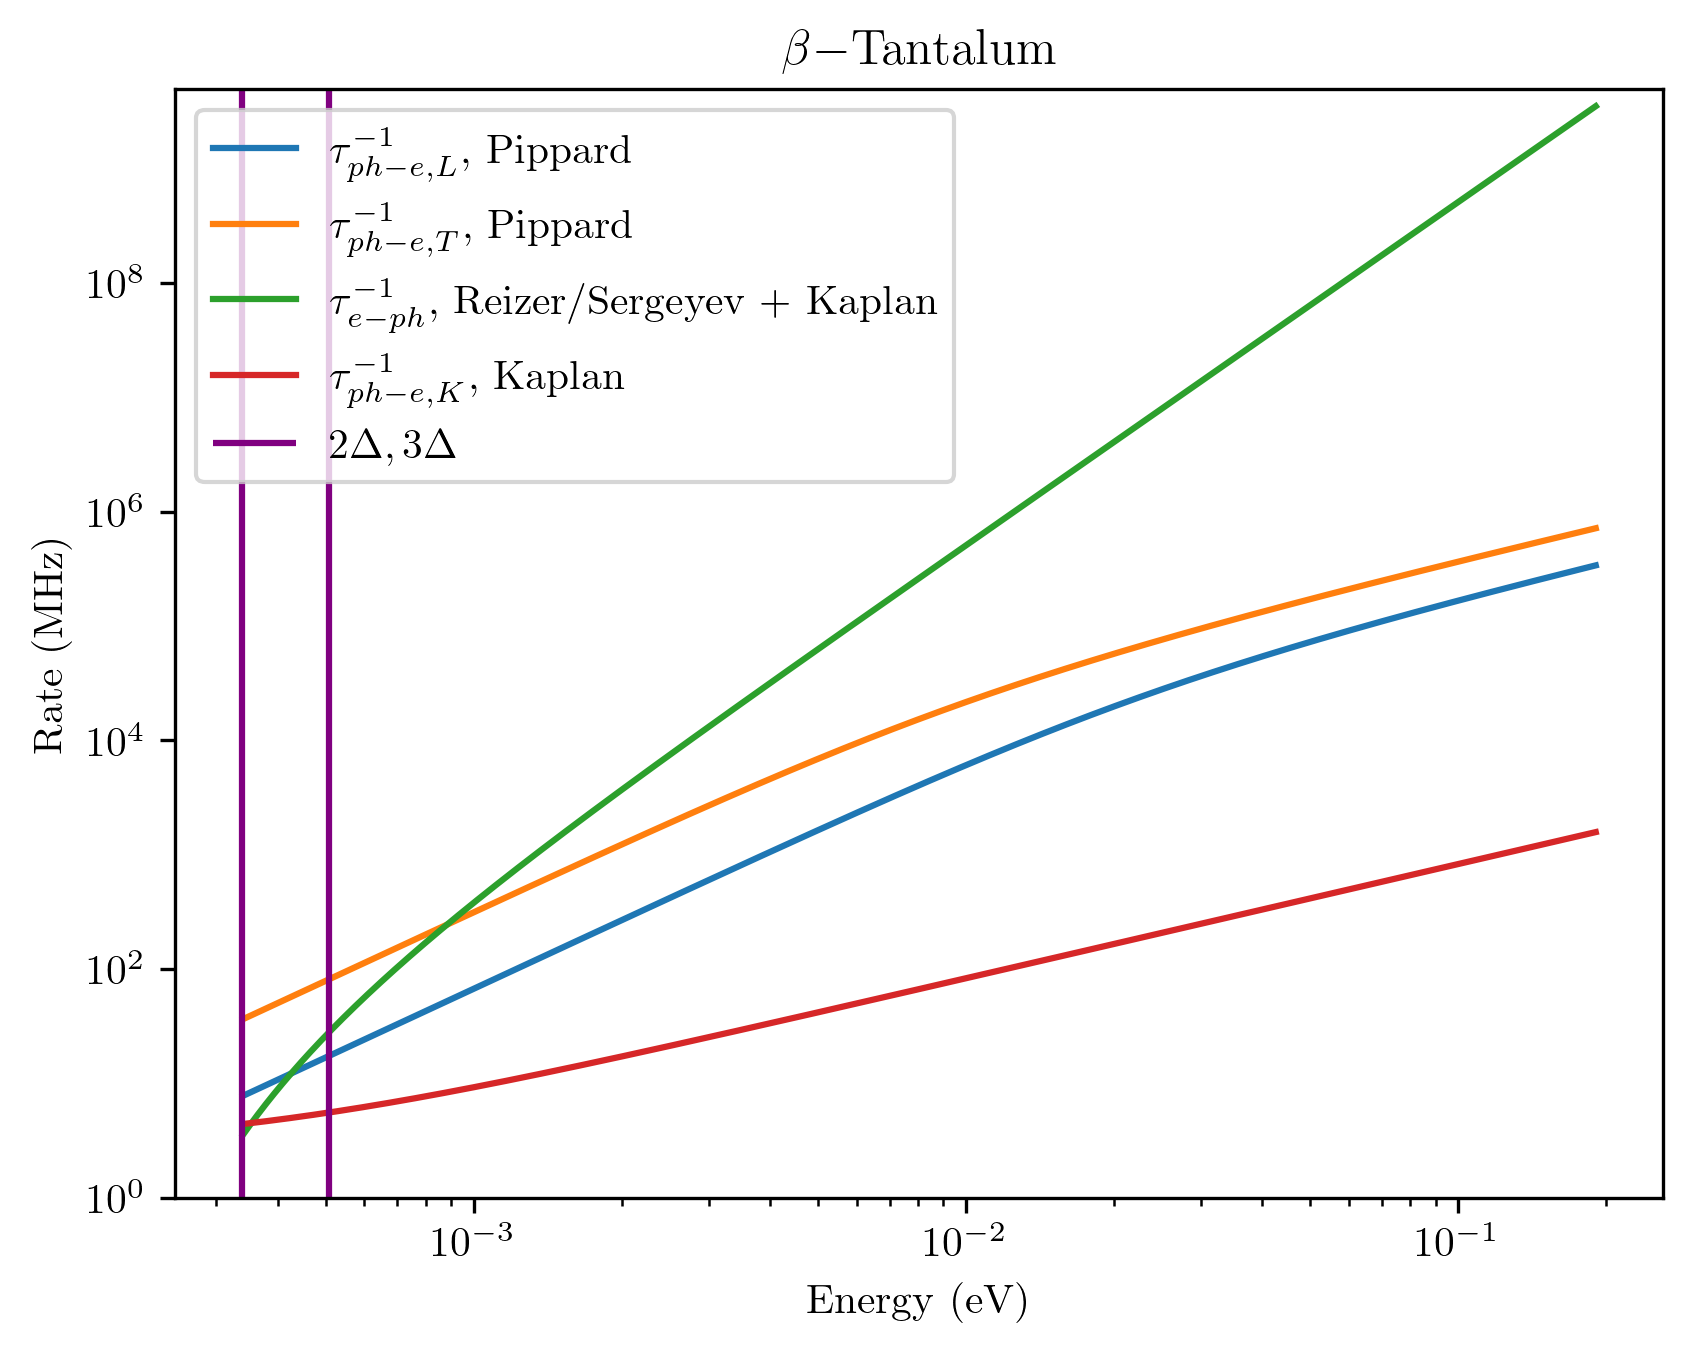

In [4]:
E_range = np.geomspace(2.01*bTa.Delta,10*bTa.E_D,1000)
tau_ee = calc_LP(bTa,E_range)
tau_ph_L,tau_ph_T = calc_pippard(bTa,E_range)
tau_s,tau_B = calc_kaplan(bTa,E_range,T)

plt.figure()
#plt.loglog(E_range,1/tau_ee,label=r'$\frac{1}{\tau_{e-e}}$')
plt.loglog(E_range,1/tau_ph_L,label=r'$\tau_{ph-e,L}^{-1}$, Pippard')
plt.loglog(E_range,1/tau_ph_T,label=r'$\tau_{ph-e,T}^{-1}$, Pippard')
plt.loglog(E_range,1/tau_s,label=r'$\tau_{e-ph}^{-1}$, Reizer/Sergeyev + Kaplan')
plt.loglog(E_range,1/tau_B,label=r'$\tau_{ph-e,K}^{-1}$, Kaplan')
#plt.loglog(E_range,1/tau_phs,label=r'$\tau_{phs}^{-1}$, Kaplan')

plt.vlines([2*bTa.Delta,3*bTa.Delta],1,5e9,colors='purple',label=r'$2\Delta,3\Delta$')
plt.ylim(1,5e9)

plt.legend()
plt.title(r'$\beta-$Tantalum')
plt.xlabel('Energy (eV)')
plt.ylabel('Rate (MHz)')
plt.show()

/tmp/ipykernel_108965/3206088173.py:22: RuntimeWarning: overflow encountered in exp
  f = lambda e : 1/(np.exp(e/(consts.k_B*T))+1)


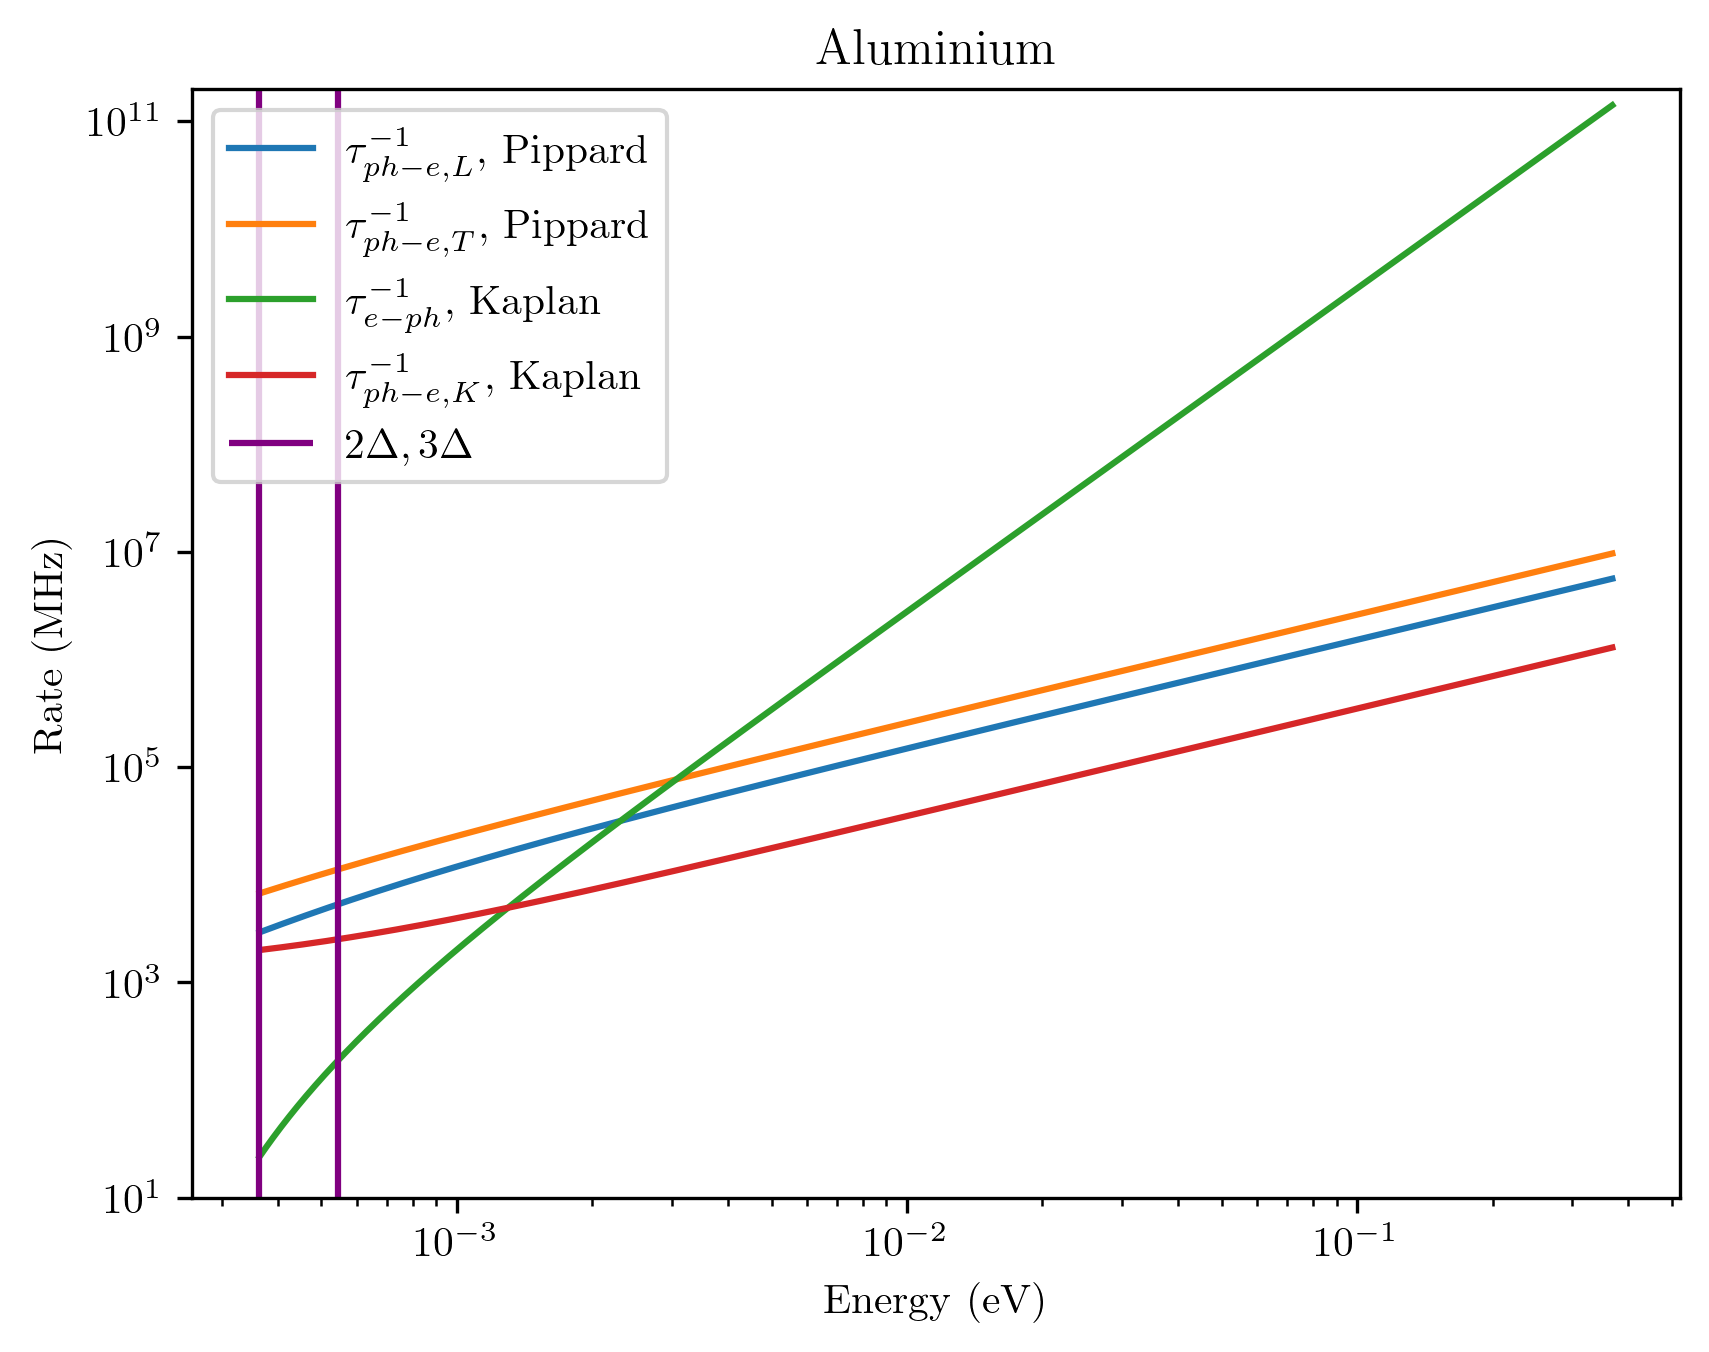

In [5]:
E_range = np.geomspace(2.01*Al.Delta,10*Al.E_D,1000)
tau_ee = calc_LP(Al,E_range)
tau_ph_L,tau_ph_T = calc_pippard(Al,E_range)
tau_s,tau_B = calc_kaplan(Al,E_range,T)

plt.figure()
#plt.loglog(E_range,1/tau_ee,label=r'$\frac{1}{\tau_{e-e}}$')
plt.loglog(E_range,1/tau_ph_L,label=r'$\tau_{ph-e,L}^{-1}$, Pippard')
plt.loglog(E_range,1/tau_ph_T,label=r'$\tau_{ph-e,T}^{-1}$, Pippard')
plt.loglog(E_range,1/tau_s,label=r'$\tau_{e-ph}^{-1}$, Kaplan')
plt.loglog(E_range,1/tau_B,label=r'$\tau_{ph-e,K}^{-1}$, Kaplan')
#plt.loglog(E_range,1/tau_phs,label=r'$\tau_{phs}^{-1}$, Kaplan')

plt.vlines([2*Al.Delta,3*Al.Delta],10,2e11,colors='purple',label=r'$2\Delta,3\Delta$')
plt.ylim(10,2e11)

plt.legend()
plt.title('Aluminium')
plt.xlabel('Energy (eV)')
plt.ylabel('Rate (MHz)')
plt.show()

# stage 1 check

In [6]:
E1 = 67*Al.E_D
tau_ee = calc_LP(Al,E1)
print('tau_ee\t\t',tau_ee)
print('tau_elastic\t',Al.tau_elastic)
print(tau_ee**-1)
print(Al.tau_elastic**-1)

tau_ee		 4.692747325956656e-09
tau_elastic	 1.2000521132629166e-08
213094788.73255584
83329714.51389898


In [7]:
lambda_au = (1/(bTa.E_D*bTa.tau_0))*(bTa.E_D/(consts.k_B*bTa.Tc))**3 * consts.energy_au*consts.time_au

E1 = 2.82*bTa.E_D*bTa.rs_au**(-1/4)*(lambda_au/3 * bTa.e_fermi/bTa.E_D)**(1/2)

tau_ee = calc_LP(bTa,E1)
print('tau_ee\t\t',tau_ee)
print('tau_elastic\t', bTa.tau_elastic) # = drude scattering time, based on diffusion measurement
print(tau_ee**-1)
print(bTa.tau_elastic**-1)

tau_ee		 2.8323914144757607e-07
tau_elastic	 3.450771260601039e-10
3530585.4794263565
2897902887.4426894


# stage 2 check

In [8]:
#Al, replacing some values with those directly from Kozorezov, to compare 1to1 with his result

E_D=36.9e-3
Delta=0.17e-3
E1 = 67*E_D

lambda0=(1/(E_D*Al.tau_0))*(E_D/(consts.k_B*Al.Tc))**3
tau1 = (3/(lambda0*E_D))*(E1/E_D)
print('tau1 = ',tau1*1e6,'ps')

tau_phD = calc_pippard(Al,E_D)
tau_phDK = calc_kaplan(Al,E_D,0.1)[1]
print(tau_phD[0]*1e6,'ps')
print(tau_phD[1]*1e6,'ps')
print(tau_phDK*1e6,'ps')

tau1 =  0.4745376414608857 ps
1.7829601425516792 ps
1.0382181727163193 ps
7.728226428638414 ps


/tmp/ipykernel_108965/3206088173.py:22: RuntimeWarning: overflow encountered in exp
  f = lambda e : 1/(np.exp(e/(consts.k_B*T))+1)


In [9]:
#bTa

lambda0=(1/(bTa.E_D*Al.tau_0))*(bTa.E_D/(consts.k_B*bTa.Tc))**3
lambda_au = (1/(bTa.E_D*Al.tau_0))*(bTa.E_D/(consts.k_B*bTa.Tc))**3 * consts.energy_au*consts.time_au
E1 = 2.82*bTa.E_D*bTa.rs_au**(-1/4)*(lambda_au/3 * bTa.e_fermi/bTa.E_D)**(1/2)
tau1 = (3/(lambda0*bTa.E_D))*(E1/bTa.E_D)
print('tau1 = ',tau1*1e6,'ps')

tau_phD = calc_pippard(bTa,bTa.E_D)
tau_phDK = calc_kaplan(bTa,bTa.E_D,0.1)[1]
print(tau_phD[0]*1e6,'ps')
print(tau_phD[1]*1e6,'ps')
print(tau_phDK*1e6,'ps')

tau1 =  1.0455081989953163 ps
54.47131418069522 ps
18.58622094433671 ps
6326.154441851676 ps


/tmp/ipykernel_108965/3206088173.py:22: RuntimeWarning: overflow encountered in exp
  f = lambda e : 1/(np.exp(e/(consts.k_B*T))+1)


# stage 3 check - phonon diffusion

In [10]:
length = 6
width = 6
height = 0.04

def distfunc(phi,theta):
    return np.min(np.stack([height/2/np.sqrt(1-np.sin(phi)**2),length/2/np.sqrt(1-np.sin(theta)**2),width/2/np.sqrt(1-np.sin(np.pi/2-theta)**2)],axis=-1),axis=-1)

mfp = dblquad(distfunc,0,np.pi/2,0,np.pi/2)[0]*4/np.pi**2

D_ph = mfp*Al.v_L/3

print(mfp)

print(D_ph, '= D (um2/us)')
mfp

0.08675605532237615
185.65795838988495 = D (um2/us)


0.08675605532237615

# Phonon lifetimes at 2 delta

In [26]:
tau_ph_L,tau_ph_T = calc_pippard(Al,2*Al.Delta)
tau_s,tau_B = calc_kaplan(Al,2.0001*Al.Delta,T)
print(tau_ph_L, tau_ph_T,tau_B)
tau_ph_L,tau_ph_T = calc_pippard(bTa,2*bTa.Delta)
tau_s,tau_B = calc_kaplan(bTa,2.0001*bTa.Delta,T)
print(tau_ph_L,tau_ph_T,tau_B)
print('average bTa ph-e time at 2Delta (us):',np.mean([tau_ph_L,tau_ph_T,tau_B]))

0.0003446479927655235 0.0001498678819696729 0.0005007931412726229
0.12963216664521093 0.027672392578328767 0.22693567611957285
average bTa ph-e time at 2Delta (us): 0.1280800784477042


/tmp/ipykernel_108965/3206088173.py:22: RuntimeWarning: overflow encountered in exp
  f = lambda e : 1/(np.exp(e/(consts.k_B*T))+1)


# QP lifetimes

In [12]:
print('Al:',Al.tau_0*Al.nue*(consts.k_B*Al.Tc)**3/(2*Al.Delta**2),'/ n_qp') # Pieter eq 2.29
print('bTa:',bTa.tau_0*bTa.nue*(consts.k_B*bTa.Tc)**3/(2*bTa.Delta**2),'/ n_qp') # Pieter eq 2.29


Al: 31034.657449747647 / n_qp
bTa: 345119.52400034654 / n_qp
